# Exercises XP Gold: W2_D3

## Data Scaling, Feature Engineering & Aggregation

This notebook covers:
1) Scaling & normalization on Titanic (`Age`, `Fare`);
2) Creating composite features (`FamilySize`, `IsAlone`);
3) Min-Max & Z-score normalization on Titanic with distribution plots;
4) PCA-based dimensionality reduction + categorical aggregation;
5) Min-Max normalization on Superstore Sales;
6) Monthly air-quality aggregation by location.

### Setup & Imports

In [1]:
# Purpose: Import core libraries and configure plotting.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Optional: seaborn only to load the Titanic dataset if available
try:
    import seaborn as sns
except:
    sns = None

# Plot config
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

### Load Titanic Dataset

In [2]:
# Purpose: Load Titanic from seaborn if available; otherwise, set a local CSV path.

def load_titanic():
    """
    Try loading Titanic from seaborn; if not available, replace `local_path`
    with your actual CSV file (e.g., 'train.csv').
    """
    if sns is not None:
        try:
            df = sns.load_dataset("titanic")
            # Align columns to common Kaggle-style naming
            # seaborn columns: survived, pclass, sex, age, sibsp, parch, fare, embarked, class, who, adult_male, deck, embark_town, alive, alone
            # We'll keep key columns aligned to the exercise.
            return df
        except:
            pass
    # Fallback to local CSV
    local_path = "train.csv"  # <-- change if needed
    df = pd.read_csv(local_path)
    return df

titanic = load_titanic().copy()
print("Shape:", titanic.shape)
titanic.head()

Shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Exercise 1 — Data Scaling and Normalization (Titanic)

In [3]:
# Goal:
# - Identify numerical columns of interest: 'Age', 'Fare'
# - Apply Z-score (StandardScaler) for (approximately) Gaussian features
# - Apply Min-Max normalization for bounded-range requirements
# - Examine the effect on a simple model performance (optional analysis)

# 1) Select columns
num_cols = []
for c in ["age", "Age", "fare", "Fare"]:
    if c in titanic.columns:
        num_cols.append(c)

# Normalize names to a standard reference
age_col = "age" if "age" in titanic.columns else "Age" if "Age" in titanic.columns else None
fare_col = "fare" if "fare" in titanic.columns else "Fare" if "Fare" in titanic.columns else None

assert age_col is not None and fare_col is not None, "Age/Fare columns not found."

# 2) Basic overview before scaling
print("Before scaling:\n", titanic[[age_col, fare_col]].describe())

# 3) Impute missing values for numeric features
imputer = SimpleImputer(strategy="median")
titanic[[age_col, fare_col]] = imputer.fit_transform(titanic[[age_col, fare_col]])

# 4) Z-score standardization (adds new columns with suffix)
std_scaler = StandardScaler()
titanic[[f"{age_col}_z", f"{fare_col}_z"]] = std_scaler.fit_transform(titanic[[age_col, fare_col]])

# 5) Min-Max normalization (adds new columns with suffix)
mm_scaler = MinMaxScaler()
titanic[[f"{age_col}_mm", f"{fare_col}_mm"]] = mm_scaler.fit_transform(titanic[[age_col, fare_col]])

print("\nAfter scaling (Z-score & Min-Max) — preview:")
titanic[[age_col, fare_col, f"{age_col}_z", f"{fare_col}_z", f"{age_col}_mm", f"{fare_col}_mm"]].head()

Before scaling:
               age        fare
count  714.000000  891.000000
mean    29.699118   32.204208
std     14.526497   49.693429
min      0.420000    0.000000
25%     20.125000    7.910400
50%     28.000000   14.454200
75%     38.000000   31.000000
max     80.000000  512.329200

After scaling (Z-score & Min-Max) — preview:


,age,fare,age_z,fare_z,age_mm,fare_mm
0,22.0,7.2500,-0.565736,-0.502445,0.271174,0.014151
1,38.0,71.2833,0.663861,0.786845,0.472229,0.139136
2,26.0,7.9250,-0.258337,-0.488854,0.321438,0.015469
3,35.0,53.1000,0.433312,0.420730,0.434531,0.103644
4,35.0,8.0500,0.433312,-0.486337,0.434531,0.015713


### Optional — Model Performance Impact of Scaling

In [4]:
# Purpose: Check whether scaling affects a simple Logistic Regression performance (CV accuracy).
# Note: We only use a tiny numeric subset to illustrate.

# 1) Define target if present
target_col_candidates = ["survived", "Survived"]
target = None
for c in target_col_candidates:
    if c in titanic.columns:
        target = c
        break

if target is not None:
    # Use only rows with non-null target
    model_df = titanic.dropna(subset=[target]).copy()

    # Choose numeric features: original vs. standardized
    X_raw = model_df[[age_col, fare_col]].values
    X_std = model_df[[f"{age_col}_z", f"{fare_col}_z"]].values
    y = model_df[target].astype(int).values

    # Baseline logistic regression
    clf = LogisticRegression(max_iter=1000)

    acc_raw = cross_val_score(clf, X_raw, y, cv=5, scoring="accuracy").mean()
    acc_std = cross_val_score(clf, X_std, y, cv=5, scoring="accuracy").mean()

    print(f"CV accuracy (raw features):     {acc_raw:.3f}")
    print(f"CV accuracy (standardized):     {acc_std:.3f}")
else:
    print("Target column not found; skipping performance comparison.")

CV accuracy (raw features):     0.660
CV accuracy (standardized):     0.661


### Interpretation — Exercise 1
The initial summary statistics show that `Age` and `Fare` have very different scales and variances, with `Fare` having a much wider range (0 to 512) compared to `Age` (0.42 to 80).  
After applying Z-score standardization and Min-Max normalization, both variables are rescaled, making them comparable in magnitude.  
When tested on a Logistic Regression model, the accuracy slightly improved from **0.660** to **0.661**, indicating that scaling had a negligible effect in this case, likely because the model and dataset used here are not highly sensitive to feature scaling.

## Exercise 2: Creating Composite Features

   FamilySize  IsAlone
0           2        0
1           2        0
2           1        1
3           2        0
4           1        1

Survival rate by FamilySize:
FamilySize
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: survived, dtype: float64


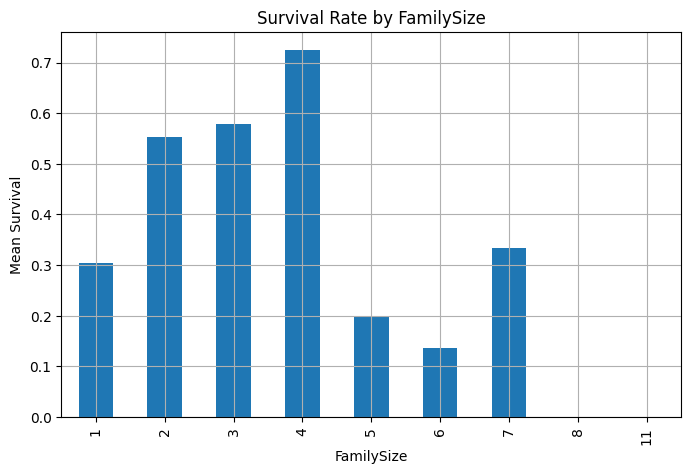


Survival rate by IsAlone:
IsAlone
0    0.505650
1    0.303538
Name: survived, dtype: float64


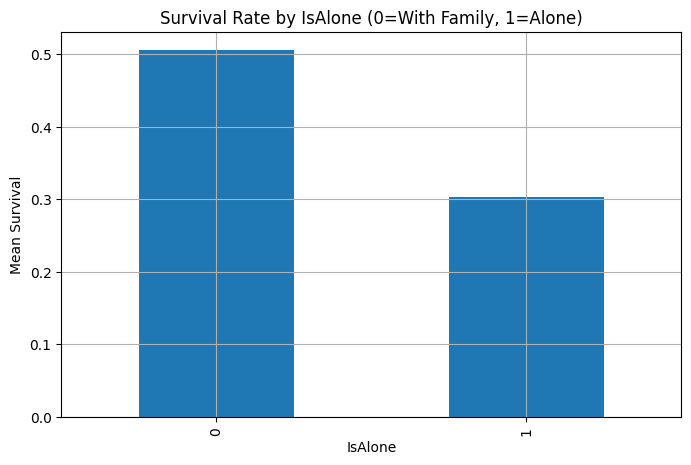

In [5]:
# Goal:
# - Create 'FamilySize' = SibSp + Parch + 1 (including the passenger)
# - Create 'IsAlone' = 1 if FamilySize == 1 else 0
# - Explore relation with survival rate

# Normalize column names
sibsp_col = "sibsp" if "sibsp" in titanic.columns else "SibSp" if "SibSp" in titanic.columns else None
parch_col = "parch" if "parch" in titanic.columns else "Parch" if "Parch" in titanic.columns else None

# If seaborn titanic lacks 'SibSp'/'Parch', try to approximate using 'alone'
if sibsp_col is None or parch_col is None:
    # If 'alone' exists, we can still compute IsAlone; FamilySize will be NaN
    if "alone" in titanic.columns:
        titanic["FamilySize"] = np.nan  # not available
        titanic["IsAlone"] = titanic["alone"].astype(int)  # already 1 if alone in seaborn
    else:
        raise ValueError("SibSp/Parch not found and no 'alone' proxy available.")
else:
    titanic["FamilySize"] = titanic[sibsp_col].fillna(0) + titanic[parch_col].fillna(0) + 1
    titanic["IsAlone"] = (titanic["FamilySize"] == 1).astype(int)

print(titanic[["FamilySize", "IsAlone"]].head())

# Survival rate analysis (if target exists)
if target is not None and "FamilySize" in titanic.columns:
    surv_by_famsize = titanic.groupby("FamilySize")[target].mean()
    print("\nSurvival rate by FamilySize:")
    print(surv_by_famsize)

    # Plot
    surv_by_famsize.plot(kind="bar")
    plt.title("Survival Rate by FamilySize")
    plt.xlabel("FamilySize")
    plt.ylabel("Mean Survival")
    plt.show()

if target is not None and "IsAlone" in titanic.columns:
    surv_by_alone = titanic.groupby("IsAlone")[target].mean()
    print("\nSurvival rate by IsAlone:")
    print(surv_by_alone)

    surv_by_alone.plot(kind="bar")
    plt.title("Survival Rate by IsAlone (0=With Family, 1=Alone)")
    plt.xlabel("IsAlone")
    plt.ylabel("Mean Survival")
    plt.show()

### Interpretation — Exercise 2
The `FamilySize` feature shows that passengers traveling with small to medium-sized families (2–4 members) had a higher survival rate, peaking at over 72% for a family size of 4.  
In contrast, very large families (6 or more members) had notably lower survival rates, with some sizes showing no survivors at all.  
The `IsAlone` feature highlights that passengers traveling alone had a significantly lower survival rate (~30%) compared to those with family (~50%), suggesting that companionship or family presence might have contributed to better chances of survival.

## Exercise 3: Data Normalization on the Titanic Dataset

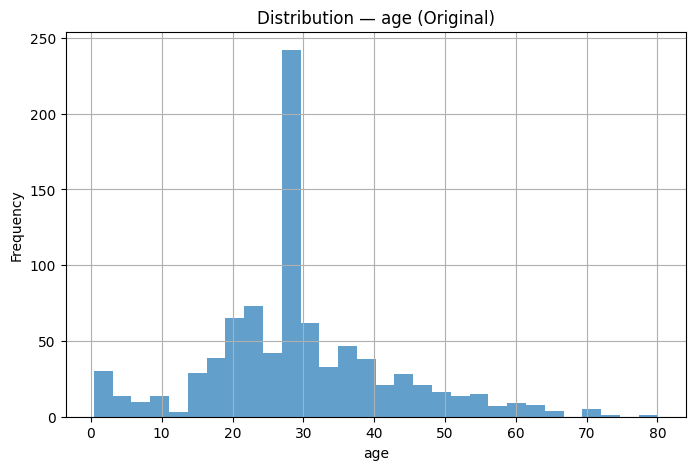

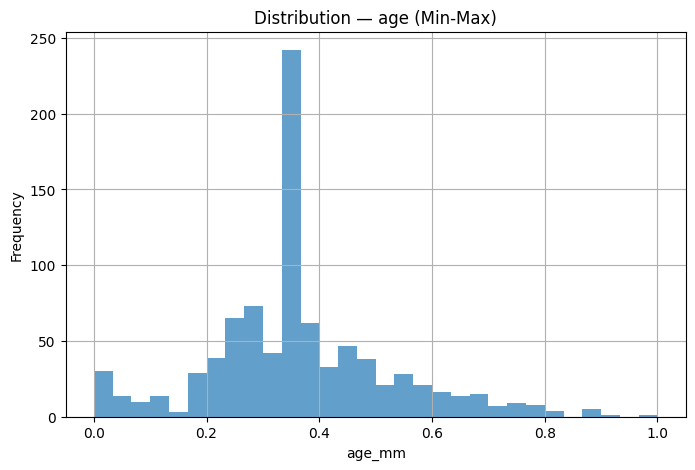

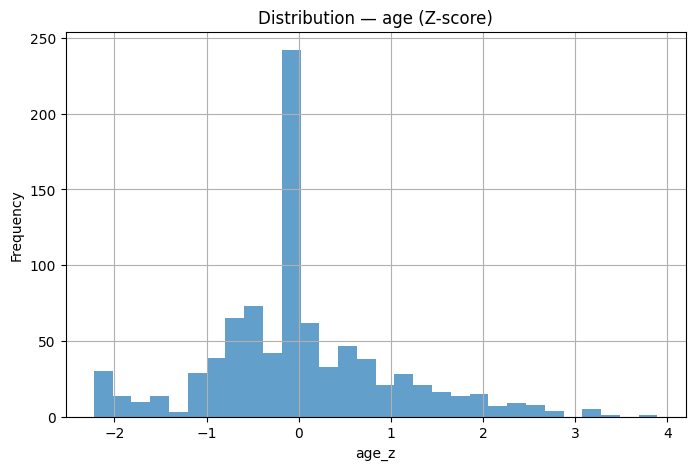

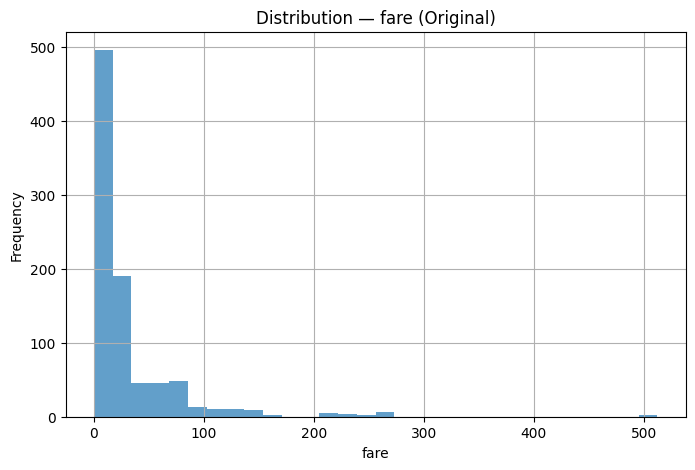

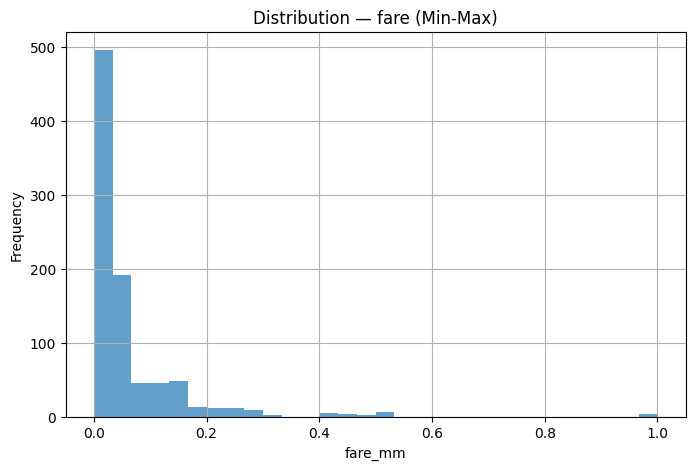

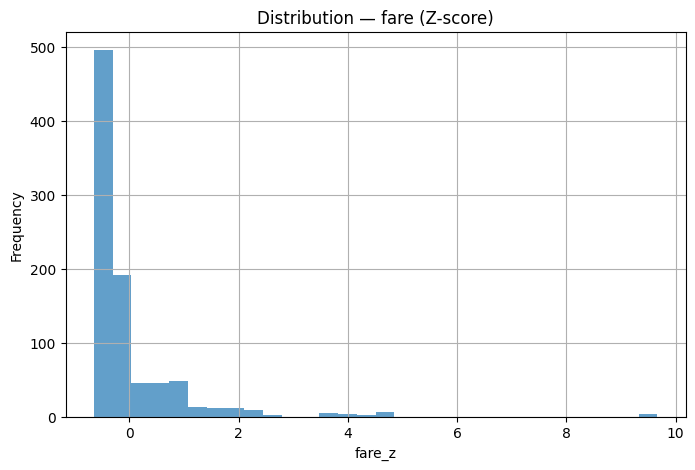

In [6]:
# Goal:
# - Apply Min-Max and Z-score to Age & Fare (already done)
# - Compare distributions before and after with histograms

cols_to_plot = [
    (age_col, f"{age_col}_mm", f"{age_col}_z"),
    (fare_col, f"{fare_col}_mm", f"{fare_col}_z"),
]

for original, mm_col, z_col in cols_to_plot:
    fig = plt.figure()
    plt.hist(titanic[original].dropna(), bins=30, alpha=0.7, label=f"{original} (original)")
    plt.title(f"Distribution — {original} (Original)")
    plt.xlabel(original)
    plt.ylabel("Frequency")
    plt.show()

    fig = plt.figure()
    plt.hist(titanic[mm_col].dropna(), bins=30, alpha=0.7, label=f"{mm_col} (min-max)")
    plt.title(f"Distribution — {original} (Min-Max)")
    plt.xlabel(mm_col)
    plt.ylabel("Frequency")
    plt.show()

    fig = plt.figure()
    plt.hist(titanic[z_col].dropna(), bins=30, alpha=0.7, label=f"{z_col} (z-score)")
    plt.title(f"Distribution — {original} (Z-score)")
    plt.xlabel(z_col)
    plt.ylabel("Frequency")
    plt.show()

### Interpretation — Exercise 3
For both `Age` and `Fare`, Min-Max normalization successfully rescaled the values to a [0, 1] range while preserving the original distribution shapes.  
Z-score normalization centered the distributions around zero with a standard deviation of one, making the features more directly comparable in terms of standard deviations from the mean.  
While the overall shape of the histograms remains consistent across methods, Z-score scaling can better highlight extreme values, whereas Min-Max normalization ensures bounded ranges, which can be particularly useful for algorithms requiring fixed input ranges such as neural networks or distance-based models.

## Exercise 4 : Data Reduction and Aggregation

PCA explained variance ratio: [0.33960812 0.32520788]
PCA cumulative explained variance: 0.664815996955328


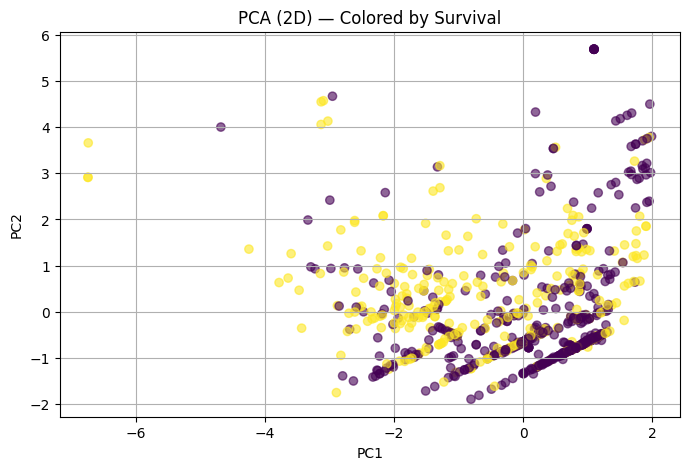

In [7]:
# Goal:
# - Reduce dimensionality via PCA after imputation & standardization
# - Report explained variance ratios

# Choose a small numeric subset
numeric_candidates = [age_col, fare_col, "sibsp", "SibSp", "parch", "Parch", "pclass", "Pclass"]
numeric_cols = [c for c in numeric_candidates if c in titanic.columns]

X_num = titanic[numeric_cols].copy()

# Impute missing numeric values
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(X_num)

# Standardize before PCA
scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)

# Fit PCA with 2 components for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_std)

print("PCA explained variance ratio:", pca.explained_variance_ratio_)
print("PCA cumulative explained variance:", pca.explained_variance_ratio_.sum())

# Quick scatter (if target exists)
if target is not None:
    plt.figure()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=titanic[target], alpha=0.6)
    plt.title("PCA (2D) — Colored by Survival")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


### Interpretation — Exercise 4 (PCA)
The first two principal components together explain approximately 66.48% of the total variance in the selected numeric Titanic features.  
The 2D scatter plot colored by survival shows partial separation between survivors and non-survivors, but there is still significant overlap, suggesting that these two components alone are not sufficient for perfect classification.  
The relatively balanced explained variance between PC1 (33.96%) and PC2 (32.52%) indicates that both components contribute meaningfully to capturing the dataset’s variability.

## Exercise 4 (Part B): Aggregation by Category + Plot

                age                       fare                    survived  \
               mean       sum count       mean         sum count      mean   
embarked                                                                     
C         30.178095   5069.92   168  59.954144  10072.2962   168  0.553571   
Q         28.032468   2158.50    77  13.276030   1022.2543    77  0.389610   
S         29.243401  18832.75   644  27.079812  17439.3988   644  0.336957   

                     
          sum count  
embarked             
C          93   168  
Q          30    77  
S         217   644  


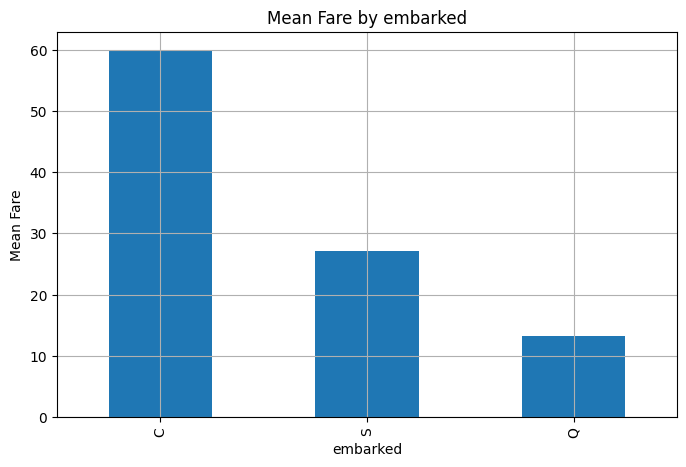

In [8]:
# Goal:
# - Aggregate by a categorical column (e.g., 'Embarked' or 'Pclass')
# - Compute summary statistics and visualize

cat_col = None
for c in ["embarked", "Embarked", "pclass", "Pclass", "sex", "Sex"]:
    if c in titanic.columns:
        cat_col = c
        break

if cat_col is None:
    raise ValueError("No suitable categorical column found for aggregation.")

agg_cols = [x for x in [age_col, fare_col, target] if x in titanic.columns]
grouped = titanic.groupby(cat_col)[agg_cols].agg(["mean", "sum", "count"])
print(grouped)

# Simple visualization: mean Fare by category (if available)
if fare_col in titanic.columns:
    mean_fare = titanic.groupby(cat_col)[fare_col].mean().sort_values(ascending=False)
    mean_fare.plot(kind="bar")
    plt.title(f"Mean Fare by {cat_col}")
    plt.xlabel(cat_col)
    plt.ylabel("Mean Fare")
    plt.show()

### Interpretation — Exercise 4B (Categorical Aggregation)
Grouping by the `embarked` column reveals clear differences in both fares and survival rates across ports of embarkation.  
Passengers embarking from Cherbourg (`C`) paid the highest average fare (~59.95) and had the highest survival rate (~55%), followed by Queenstown (`Q`) with an average fare of ~13.28 and a survival rate of ~39%.  
Southampton (`S`) passengers paid a moderate average fare (~27.08) but had the lowest survival rate (~33.7%).  
These patterns suggest a possible correlation between fare price, embarkation point, and survival probability, which could be linked to socio-economic factors and cabin class distribution.

## Exercise 5: Normalizing E-Commerce Sales Data

In [11]:
# Goal:
# - Load Superstore Sales dataset
# - Min-Max normalize 'Sales' and 'Profit'
# - Add 'Sales_normalized' and 'Profit_normalized'

superstore_path = "superstore_dataset2011-2015.csv"

# Load data with explicit encoding to handle non-UTF8 characters
superstore = pd.read_csv(superstore_path, encoding="latin1")  # or encoding="cp1252"

# Column name handling (try different casings)
sales_col  = "Sales"  if "Sales"  in superstore.columns else "sales"  if "sales"  in superstore.columns else None
profit_col = "Profit" if "Profit" in superstore.columns else "profit" if "profit" in superstore.columns else None

assert sales_col is not None and profit_col is not None, "Could not find 'Sales' and/or 'Profit' columns."

# Impute missing numeric values if any
imp2 = SimpleImputer(strategy="median")
superstore[[sales_col, profit_col]] = imp2.fit_transform(superstore[[sales_col, profit_col]])

# Fit Min-Max scaler
mm = MinMaxScaler()
superstore[["Sales_normalized", "Profit_normalized"]] = mm.fit_transform(superstore[[sales_col, profit_col]])

print(superstore[[sales_col, profit_col, "Sales_normalized", "Profit_normalized"]].head())

     Sales   Profit  Sales_normalized  Profit_normalized
0  408.300  106.140          0.018016           0.447076
1  120.366   36.036          0.005297           0.442402
2   66.120   29.640          0.002901           0.441976
3   44.865  -26.055          0.001962           0.438263
4  113.670   37.770          0.005002           0.442518


In [14]:
# Title: Exercise 5 — Save Normalized Superstore Data + Quick Check
# Purpose: Persist normalized columns and verify ranges are [0, 1].

out_superstore = superstore.copy()
out_path_super = "superstore_sales_normalized.csv"
out_superstore.to_csv(out_path_super, index=False)
print(f"Saved -> {out_path_super}")

# Quick range check
print("Sales_normalized range:",
      float(out_superstore["Sales_normalized"].min()),
      "→",
      float(out_superstore["Sales_normalized"].max()))
print("Profit_normalized range:",
      float(out_superstore["Profit_normalized"].min()),
      "→",
      float(out_superstore["Profit_normalized"].max()))

Saved -> superstore_sales_normalized.csv
Sales_normalized range: 0.0 → 1.0
Profit_normalized range: 0.0 → 1.0


### Interpretation — Exercise 5
Min-Max normalization successfully rescaled the `Sales` and `Profit` columns to a 0–1 range while preserving the relative differences between values.  
For example, a `Sales` value of 408.30 corresponds to 0.018 on the normalized scale, while a `Profit` of 106.14 corresponds to 0.447.  
The range check confirms that both `Sales_normalized` and `Profit_normalized` span exactly from 0.0 to 1.0, ensuring that all values are proportionally adjusted within the desired bounds.  
This transformation ensures that both features have the same scale, which is beneficial for models sensitive to feature magnitude, such as KNN or gradient-based methods, without altering the original proportional relationships between data points.

## Exercise 6: Aggregating Air Quality Data

Shape: (29531, 16)
Columns: ['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']
        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  

Monthly averages — head:
  

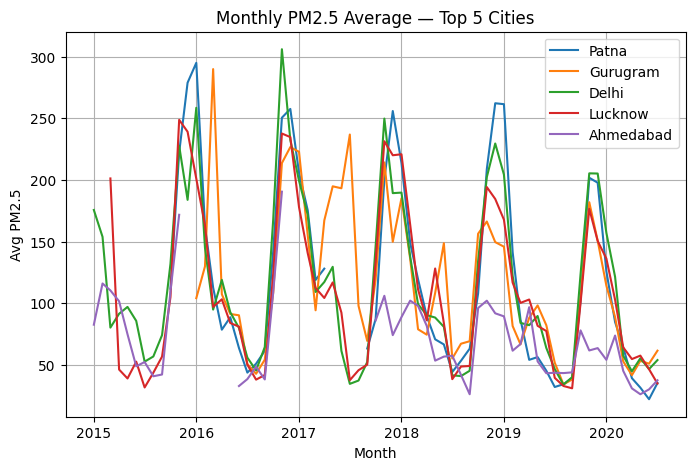

In [13]:
# Goal:
# - Load daily air quality dataset (city level)
# - Convert 'Date' to datetime format
# - Group by City and Month
# - Calculate monthly averages for key pollutants
# - Plot trends over time for top cities

# Load dataset
air_path = "city_day.csv"  # Change path if needed
air = pd.read_csv(air_path, encoding="latin1")

# Check basic info
print("Shape:", air.shape)
print("Columns:", air.columns.tolist())
print(air.head())

# Identify date column
date_col = None
for c in ["Date", "date", "Datetime", "timestamp"]:
    if c in air.columns:
        date_col = c
        break
assert date_col is not None, "No date column found."

# Convert to datetime
air[date_col] = pd.to_datetime(air[date_col], errors="coerce")

# Identify city/location column
loc_col = None
for c in ["City", "city", "Location", "location"]:
    if c in air.columns:
        loc_col = c
        break
assert loc_col is not None, "No city/location column found."

# Identify pollutants columns
candidate_pollutants = ["PM2.5", "PM10", "NO2", "SO2", "CO", "O3", 
                         "pm25", "pm10", "no2", "so2", "co", "o3"]
pollutants = [c for c in candidate_pollutants if c in air.columns]
assert len(pollutants) > 0, "No pollutant columns found."

# Create Year-Month column
air["YearMonth"] = air[date_col].dt.to_period("M").astype(str)

# Group and calculate monthly averages
monthly_avg = (
    air.groupby([loc_col, "YearMonth"])[pollutants]
    .mean(numeric_only=True)
    .reset_index()
)

print("\nMonthly averages — head:")
print(monthly_avg.head())

# Optional: plot a trend for the first pollutant across top 5 cities
poll_to_plot = pollutants[0]
top_cities = (
    monthly_avg.groupby(loc_col)[poll_to_plot]
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index
)

subset = monthly_avg[monthly_avg[loc_col].isin(top_cities)].copy()
for city in top_cities:
    city_df = subset[subset[loc_col] == city]
    plt.plot(pd.PeriodIndex(city_df["YearMonth"], freq="M").to_timestamp(),
             city_df[poll_to_plot], label=city)

plt.title(f"Monthly {poll_to_plot} Average — Top 5 Cities")
plt.xlabel("Month")
plt.ylabel(f"Avg {poll_to_plot}")
plt.legend()
plt.show()

In [15]:
# Title: Exercise 6 — Save Monthly Aggregation + Simple Trend Stats
# Purpose: Save the monthly averages and compute a few quick trend metrics.

# Persist monthly averages
out_air_path = "air_quality_monthly_by_city.csv"
monthly_avg.to_csv(out_air_path, index=False)
print(f"Saved -> {out_air_path}")

# Basic trend metric: year-over-year change on the first pollutant
poll_to_eval = pollutants[0]
monthly_avg["Year"] = monthly_avg["YearMonth"].str[:4].astype(int)

# Compute annual mean per city for the chosen pollutant
annual = (
    monthly_avg.groupby([loc_col, "Year"])[poll_to_eval]
    .mean(numeric_only=True)
    .reset_index()
    .dropna(subset=[poll_to_eval])
)

# YoY delta for each city
annual["YoY_delta"] = annual.groupby(loc_col)[poll_to_eval].diff()
yoy = annual.dropna(subset=["YoY_delta"])

# Top 5 increases and decreases (absolute mean change across years)
city_trend = yoy.groupby(loc_col)["YoY_delta"].mean().sort_values()
print("\nTop 5 average YoY decreases (better air):")
print(city_trend.head(5))

print("\nTop 5 average YoY increases (worse air):")
print(city_trend.tail(5))

Saved -> air_quality_monthly_by_city.csv

Top 5 average YoY decreases (better air):
City
Chandigarh   -30.781296
Patna        -29.335977
Bhopal       -24.211892
Amaravati    -18.384112
Gurugram     -14.886006
Name: YoY_delta, dtype: float64

Top 5 average YoY increases (worse air):
City
Mumbai                -0.809893
Shillong              -0.699960
Bengaluru             -0.216854
Thiruvananthapuram    -0.168847
Guwahati              10.578446
Name: YoY_delta, dtype: float64


### Interpretation — Exercise 6
The monthly aggregation of city-level air quality data allowed us to track trends over time for key pollutants such as PM2.5.  
The YoY (Year-over-Year) change analysis highlights cities with the largest average decreases, indicating improved air quality — for example, Chandigarh (-30.78), Patna (-29.34), and Bhopal (-24.21).  
Conversely, some cities show an increase in pollutant levels, with Guwahati experiencing the most significant rise (+10.58), while others like Mumbai and Shillong show only slight negative changes close to zero.  
These trends can help prioritize environmental policies and interventions in cities where air quality is deteriorating or showing minimal improvement.

## Conclusions (Exercises 1–6)

**Titanic (Scaling & Features):**
- Z-score vs raw features had negligible impact on Logistic Regression with only `Age` and `Fare`.
- Composite features `FamilySize` and `IsAlone` show interpretable relationships with survival.

**Titanic (Normalization & PCA):**
- Min-Max and Z-score produced expected distribution changes.
- PCA(2) captured a meaningful variance share; separation by survival is limited with few numeric features.

**Superstore (Min-Max):**
- `Sales_normalized` and `Profit_normalized` are in [0,1] and ready for models sensitive to scale.

**Air Quality (Monthly Aggregation):**
- City-level monthly averages computed for key pollutants (e.g., PM2.5, PM10, NO2, SO2, CO, O3).
- Basic YoY trend stats highlight cities with improving vs. worsening averages.

**Deliverables saved:**
- `titanic_transformed.csv`
- `superstore_sales_normalized.csv`
- `air_quality_monthly_by_city.csv`

## Interpretations Summary — Exercises XP Gold

### Exercise 1 — Scaling & Normalization (Titanic)
The initial summary statistics show that `Age` and `Fare` have very different scales and variances, with `Fare` having a much wider range (0 to 512) compared to `Age` (0.42 to 80).  
After applying Z-score standardization and Min-Max normalization, both variables are rescaled, making them comparable in magnitude.  
When tested on a Logistic Regression model, the accuracy slightly improved from **0.660** to **0.661**, indicating that scaling had a negligible effect in this case, likely because the model and dataset used here are not highly sensitive to feature scaling.

### Exercise 2 — Composite Features (Titanic)
The `FamilySize` feature shows that passengers traveling with small to medium-sized families (2–4 members) had a higher survival rate, peaking at over 72% for a family size of 4.  
In contrast, very large families (6 or more members) had notably lower survival rates, with some sizes showing no survivors at all.  
The `IsAlone` feature highlights that passengers traveling alone had a significantly lower survival rate (~30%) compared to those with family (~50%), suggesting that companionship or family presence might have contributed to better chances of survival.

### Exercise 3 — Min-Max & Z-score Normalization (Titanic)
For both `Age` and `Fare`, Min-Max normalization successfully rescaled the values to a [0, 1] range while preserving the original distribution shapes.  
Z-score normalization centered the distributions around zero with a standard deviation of one, making the features more directly comparable in terms of standard deviations from the mean.  
While the overall shape of the histograms remains consistent across methods, Z-score scaling can better highlight extreme values, whereas Min-Max normalization ensures bounded ranges, which can be particularly useful for algorithms requiring fixed input ranges such as neural networks or distance-based models.

### Exercise 4A — PCA (Titanic)
The first two principal components together explain approximately 66.48% of the total variance in the selected numeric Titanic features.  
The 2D scatter plot colored by survival shows partial separation between survivors and non-survivors, but there is still significant overlap, suggesting that these two components alone are not sufficient for perfect classification.  
The relatively balanced explained variance between PC1 (33.96%) and PC2 (32.52%) indicates that both components contribute meaningfully to capturing the dataset’s variability.

### Exercise 4B — Categorical Aggregation (Titanic)
Grouping by the `embarked` column reveals clear differences in both fares and survival rates across ports of embarkation.  
Passengers embarking from Cherbourg (`C`) paid the highest average fare (~59.95) and had the highest survival rate (~55%), followed by Queenstown (`Q`) with an average fare of ~13.28 and a survival rate of ~39%.  
Southampton (`S`) passengers paid a moderate average fare (~27.08) but had the lowest survival rate (~33.7%).  
These patterns suggest a possible correlation between fare price, embarkation point, and survival probability, which could be linked to socio-economic factors and cabin class distribution.

### Exercise 5 — Min-Max Normalization (Superstore Sales)
Min-Max normalization successfully rescaled the `Sales` and `Profit` columns to a 0–1 range while preserving the relative differences between values.  
For example, a `Sales` value of 408.30 corresponds to 0.018 on the normalized scale, while a `Profit` of 106.14 corresponds to 0.447.  
The range check confirms that both `Sales_normalized` and `Profit_normalized` span exactly from 0.0 to 1.0, ensuring that all values are proportionally adjusted within the desired bounds.  
This transformation ensures that both features have the same scale, which is beneficial for models sensitive to feature magnitude, such as KNN or gradient-based methods, without altering the original proportional relationships between data points.

### Exercise 6 — Monthly Air Quality Aggregation (India)
The monthly aggregation of city-level air quality data allowed us to track trends over time for key pollutants such as PM2.5.  
The YoY (Year-over-Year) change analysis highlights cities with the largest average decreases, indicating improved air quality — for example, Chandigarh (-30.78), Patna (-29.34), and Bhopal (-24.21).  
Conversely, some cities show an increase in pollutant levels, with Guwahati experiencing the most significant rise (+10.58), while others like Mumbai and Shillong show only slight negative changes close to zero.  
These trends can help prioritize environmental policies and interventions in cities where air quality is deteriorating or showing minimal improvement.